In [43]:
import os
import nibabel as nib
import numpy as np
import nilearn
from nilearn import image
import pandas as pd
from hampel import hampel
import scipy.stats as stats
import matplotlib.pyplot as plt

In [44]:
# data_dir = '/arc/project/st-ipor-1/mkhademi/BOLD5000_2.0/'
# output_dir = '/scratch/st-ipor-1/mkhademi/'
output_dir = 'C:\\Users\\mahkh\\Documents\\'
roi_dir = output_dir + 'image_data\\parcels\\'
subjs = ['CSI1', 'CSI2', 'CSI3', 'CSI4']
roi_names =['lFFA','rFFA','lOFA','rOFA','lSTS','rSTS','lLOC','rLOC','lPPA','rPPA','lRSC','rRSC','lTOS','rTOS','lEBA','rEBA']
roi_voxels = {'lFFA': 531, 'rFFA': 1019, 'lOFA': 211, 'rOFA': 790, 'lSTS': 844, 'rSTS': 2505, 'lLOC': 4971, 'rLOC': 5085,
             'lPPA': 732, 'rPPA': 553, 'lRSC': 1063, 'rRSC': 1741, 'lTOS': 133, 'rTOS': 251, 'lEBA': 2155, 'rEBA': 2413}

In [45]:
sub = subjs[2]
#sub = 'all'
j = 90 # face
dif = nib.load(output_dir + 'image_data/vis/dif-' + sub + '-c' + str(j) + '.nii.gz') 
dif = nilearn.image.resample_img(dif, target_shape=(79, 95, 69), target_affine=dif.affine)
dif = np.array(dif.dataobj)
#dif = dif[6:91-6, 7:109-7, 11:91-11]
dif_rois = []
no_roi = np.ones((79, 95, 69), dtype=np.uint8)
for roi_name in roi_names:
    roi = nib.load(roi_dir + roi_name + '.img')
    roi = np.array(roi.dataobj)
    no_roi[np.nonzero(roi)] = 0
    tmp = dif[np.nonzero(roi)]
    tmp[tmp == 0.0] = np.nan
    dif_rois.append(np.nanmedian(tmp))

C:\Users\mahkh\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [46]:
dif_rois = np.array(dif_rois)
tmp = dif[np.nonzero(no_roi)]
tmp[tmp == 0.0] = np.nan
print('rest' + ':', np.round(np.nanmedian(tmp), 8)) 
for i, roi_name in enumerate(roi_names): 
    print(roi_name + ':', np.round(dif_rois[i], 8))

rest: -0.00041401
lFFA: 0.00097913
rFFA: 0.00239322
lOFA: -0.01783256
rOFA: nan
lSTS: -0.0039537
rSTS: -0.00240691
lLOC: -0.00365277
rLOC: 0.00277211
lPPA: 0.00039224
rPPA: 0.00076311
lRSC: -0.00093677
rRSC: -0.00152131
lTOS: 0.00155469
rTOS: -0.00157136
lEBA: -0.00751665
rEBA: 0.00811107


In [47]:
igs = nib.load(output_dir + 'image_data/vis/igs-' + sub + '-c' + str(j) + '.nii.gz') 
igs = nilearn.image.resample_img(igs, target_shape=(79, 95, 69), target_affine=igs.affine)
igs = np.array(igs.dataobj)
#igs = igs[6:91-6, 7:109-7, 11:91-11]

tmp = igs.reshape(-1)
tmp[tmp == 0.0] = np.nan
tmp = tmp[~np.isnan(tmp)]
p_pos = np.nanpercentile(tmp, 90)
print("p_90", p_pos)
p_neg = np.nanpercentile(tmp, 10)
print("p_10", p_neg)

igs_rois = []
all_prop_pos = []
all_prop_neg = []
no_roi = np.ones((79, 95, 69), dtype=np.uint8)
for roi_name in roi_names:
    roi = nib.load(roi_dir + roi_name + '.img')
    roi = np.array(roi.dataobj)
    no_roi[np.nonzero(roi)] = 0
    tmp = igs[np.nonzero(roi)]
    tmp[tmp == 0.0] = np.nan
    tmp = tmp[~np.isnan(tmp)]
    igs_rois.append(np.nanmedian(tmp))
    prop = 0.0
    for x in tmp:
        if x > p_pos:
            prop += 1
    all_prop_pos.append(prop/len(tmp))
    prop = 0.0
    for x in tmp:
        if x < p_neg:
            prop += 1
    all_prop_neg.append(prop/len(tmp))

p_90 0.00013467059470713142
p_10 -0.00013182304974179715


In [48]:
igs_rois = np.array(igs_rois)   
tmp = igs[np.nonzero(no_roi)]
tmp[tmp == 0.0] = np.nan
##
prop = 0.0
for x in tmp:
    if x > p_pos:
        prop += 1
all_prop_pos.append(prop/len(tmp))
##
print('\n')
##
prop = 0.0
for x in tmp:
    if x < p_neg:
        prop += 1
all_prop_neg.append(prop/len(tmp))
##
print('\nMedian IGs:')   
print('rest' + ':', np.round(np.nanmedian(tmp), 8))
for i, roi_name in enumerate(roi_names): 
    print(roi_name + ':', np.round(igs_rois[i], 8))




Median IGs:
rest: 0.0
lFFA: -4.54e-06
rFFA: 0.0
lOFA: -0.0
rOFA: 0.0
lSTS: 4.133e-05
rSTS: 0.0
lLOC: -0.0
rLOC: 0.0
lPPA: 1.708e-05
rPPA: 3.493e-05
lRSC: 6.87e-06
rRSC: 2.6e-07
lTOS: 4.553e-05
rTOS: 0.0
lEBA: -1.8e-07
rEBA: -0.0


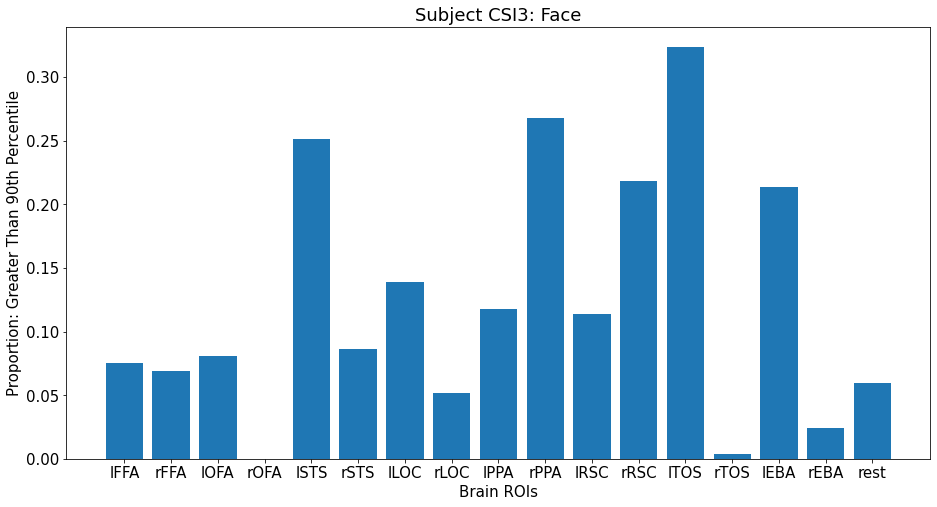

In [49]:
fig = plt.figure()
fig.set_size_inches(12, 6)
plt.rc('font', size=15)
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Proportion: Greater Than 90th Percentile')
ax.set_xlabel('Brain ROIs')
ax.set_title('Subject ' + sub + ': Face')
ax.bar(roi_names+['rest'],all_prop_pos)
plt.show()

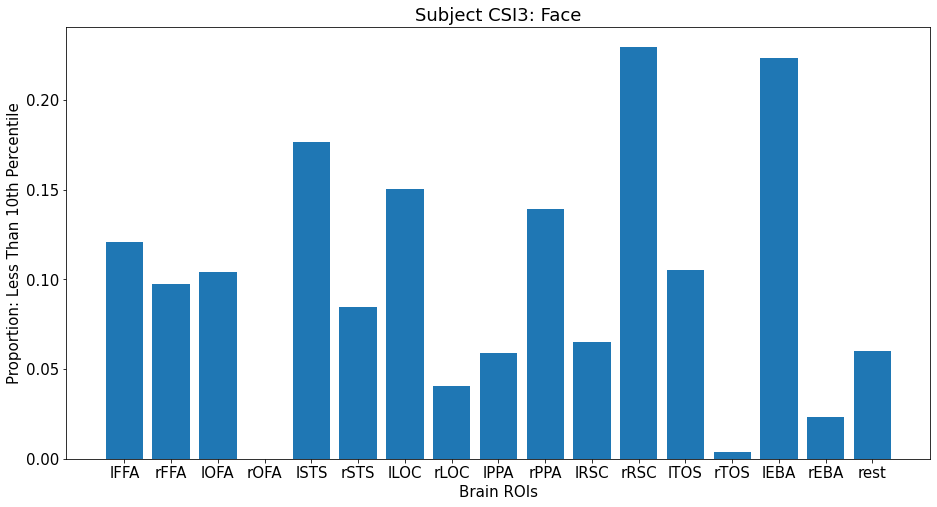

In [50]:
fig = plt.figure()
fig.set_size_inches(12, 6)
plt.rc('font', size=15)
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Proportion: Less Than 10th Percentile')
ax.set_xlabel('Brain ROIs')
ax.set_title('Subject ' + sub + ': Face')
ax.bar(roi_names+['rest'],all_prop_neg)
plt.show()

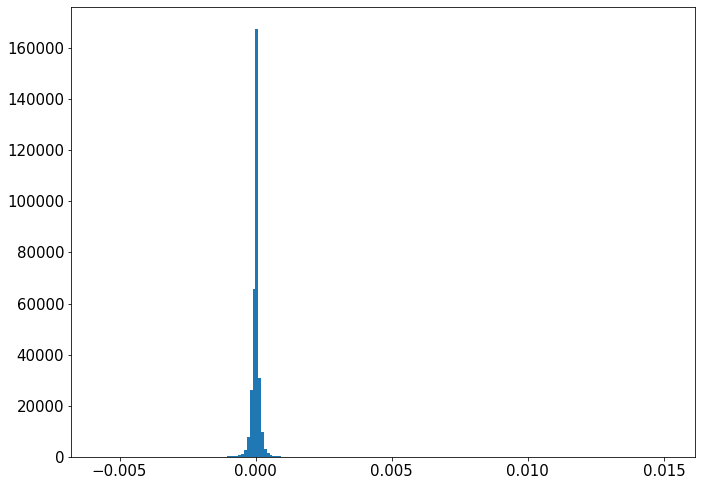

In [51]:
igs = nib.load(output_dir + 'image_data/vis/igs-' + sub + '-c' + str(j) + '.nii.gz') 
igs = nilearn.image.resample_img(igs, target_shape=(79, 95, 69), target_affine=igs.affine)
igs = np.array(igs.dataobj)
#igs = igs[6:91-6, 7:109-7, 11:91-11]

tmp = igs.reshape(-1)
tmp[tmp == 0.0] = np.nan
tmp = tmp[~np.isnan(tmp)]
fig, axs = plt.subplots(1, 1, figsize =(10, 7), tight_layout = True)
axs.hist(tmp, bins=200)
# Show plot
plt.show()